# Week 8 Exercise- Stewart Wilson

In this week's exercise I am tasked with creating a predictive model from time series data. Particualry, I must build a model to predict the last 12 month's sales for a given retail company. Time series data can be tricky with, particularly when it has seasonality and trends. I hope that through doing this exercise I will gain a better understanding of how to tune a time series predictive model to help account for these challenges. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

## Importing and Cleaning Data

In [3]:
retail_df = pd.read_csv("us_retail_sales.csv")

In [4]:
retail_df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0
5,1997,202371,204286,204990,203399,201699,204675,207014.0,207635.0,208326.0,208078.0,208936.0,209363.0
6,1998,209666,209552,210832,213633,214639,216337,214841.0,213636.0,215720.0,219483.0,221134.0,223179.0
7,1999,223997,226250,227417,229037,231235,231903,233948.0,236566.0,237481.0,237553.0,240544.0,245485.0
8,2000,243436,247133,249825,245831,246201,248160,247176.0,247576.0,251837.0,251221.0,250331.0,250658.0
9,2001,252654,252704,250328,254763,255218,254022,252997.0,254560.0,249845.0,267999.0,260514.0,256549.0


In [5]:
# melt into long data frame
retail_long = pd.melt(retail_df, id_vars = "YEAR", var_name="Month", value_name="Sales")

In [6]:
retail_long

,YEAR,Month,Sales
0,1992,JAN,146925.0
1,1993,JAN,157555.0
2,1994,JAN,167518.0
3,1995,JAN,182413.0
4,1996,JAN,189135.0
...,...,...,...
355,2017,DEC,433282.0
356,2018,DEC,434803.0
357,2019,DEC,458055.0
358,2020,DEC,484782.0


In [7]:
# connect month and year together
retail_long["Month"] = retail_long.Month + " " + retail_long.YEAR.map(str)

In [8]:
retail_long = retail_long.drop("YEAR", axis = 1)

In [9]:
# convert into datetime and sort
retail_long["Month"] = pd.to_datetime(retail_long.Month, format="%b %Y",dayfirst=True)
retail_long = retail_long.sort_values("Month")
retail_long = retail_long.set_index("Month")

In [10]:
retail_long

,Sales
Month,
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0
...,...
2021-08-01,NaN
2021-09-01,NaN
2021-10-01,NaN


## Graphing Time Series Data

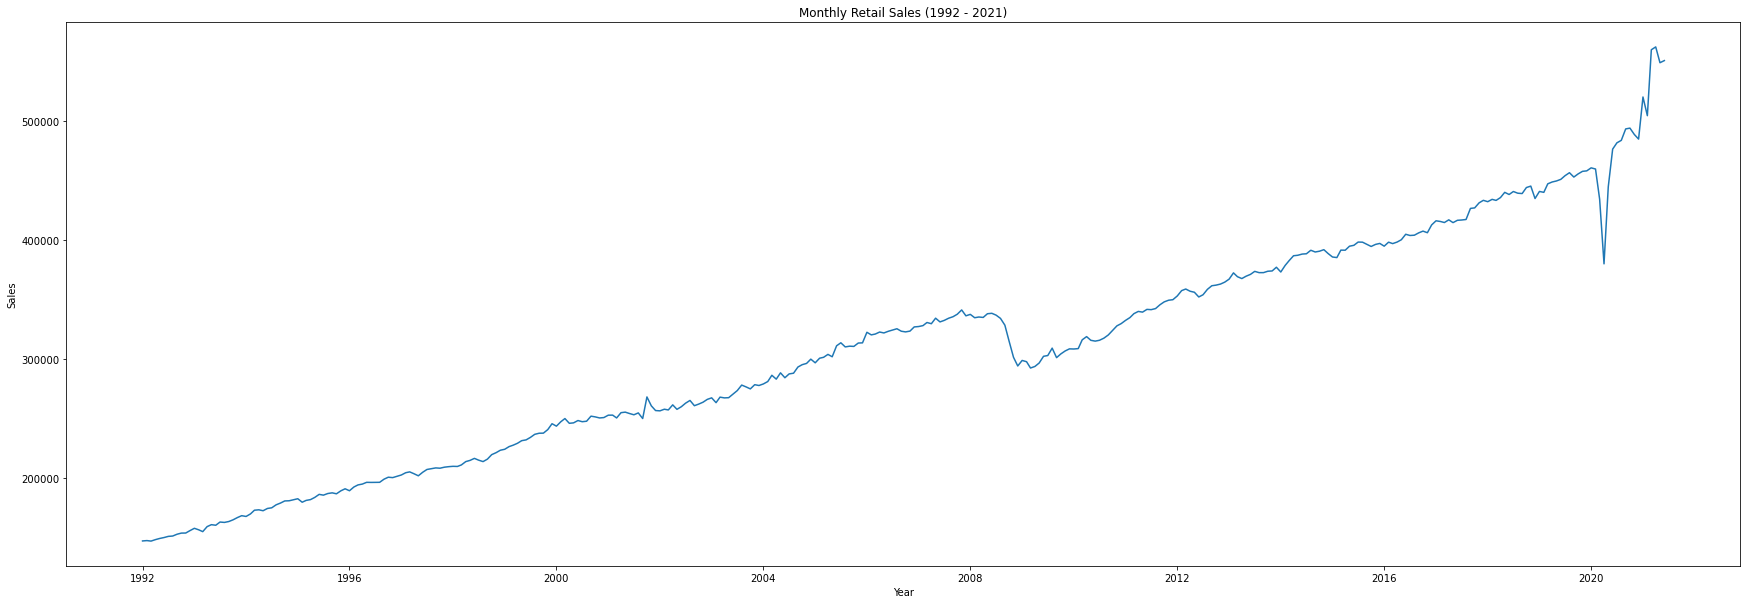

In [11]:
plt.figure(figsize=(30,10))
sns.lineplot(x="Month", y="Sales", data=retail_long)
plt.xlabel("Year")
plt.title("Monthly Retail Sales (1992 - 2021)")
plt.show()

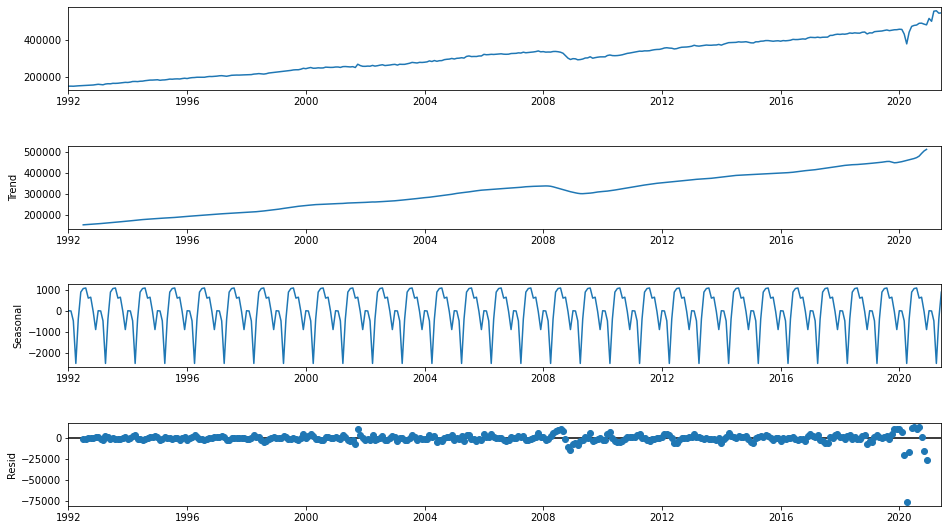

In [12]:
# look for trends and seasonality for model
res = sm.tsa.seasonal_decompose(retail_long.dropna(), period=12)
fig=res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

The graph above shows a consistent increase in monthly sales over the last thirty years. There have been two noticeable declines, in 2008 and 2020. These declines likely relate to the financial crises of the Great Recession and the Covid-19 pandemic respectively. There seems to be a sharp incline in sales post-2020. It will be interesting to see how the model I build can predict these future values given the linear nature of the retail sales up to that point. 

By decomposing the time series we can also see that there is a steady upwards trend and seasonality of the data throughout each year.

## Building a Predictive Model

### Splitting Data

In [13]:
# split data into test-train with test set being the period from July 2020 to June 2021
train =  retail_long['1992-01-01':'2020-06-01']
test = retail_long['2020-07-01':'2021-06-01']

### Checking for Hyperparemeters

Note that this section is imperfect and the values that are derived from this section ultimately did not produce the best model

In [14]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [15]:
# check to see if series is stationary for d-value
seasonal = res.seasonal
check_stationarity(seasonal)

The series is stationary


Series is stationary so d can be 0

C:\Users\Stewart\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


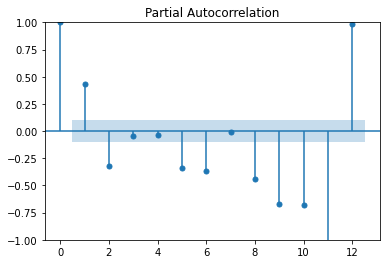

In [16]:
# looking for p value by checking partial autocorrelation
plot_pacf(seasonal, lags =12)
plt.show()

Max lag outside confidence interval is 12 so P can be 12 and

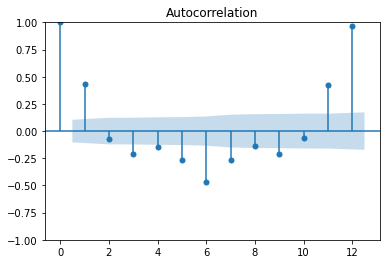

In [17]:
# look at autocorrelation plot for q value
plot_acf(seasonal, lags =12)
plt.show()

Max lag within the confidence interval is 10 so Q can be 12 and P 

### Building SARIMA Model

I built the model multiple times with different values for (p, d, q) and (P, D, Q, S) including what I found in the analysis above. The resulting model below gave the lowest RMSE. 

In [125]:
# train SARIMAX Model with p, d, q being 0, 3, 4 and P, D, Q, S being 1, 0, 1, 12
model = SARIMAX(train, order = (0, 3, 4), seasonal_order=(1, 0, 1, 12))

C:\Users\Stewart\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Stewart\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [126]:
model_fit = model.fit()

C:\Users\Stewart\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Predicting Test Set

In [127]:
# use forecast to predict the test set (12 months past training set)
predictions = model_fit.forecast(steps=test.shape[0])

In [128]:
# view predictions
predictions

2020-07-01    492508.002092
2020-08-01    496968.451249
2020-09-01    499123.228265
2020-10-01    501180.312069
2020-11-01    503287.887230
2020-12-01    505615.923131
2021-01-01    507751.316539
2021-02-01    509986.710836
2021-03-01    512672.339636
2021-04-01    516016.278982
2021-05-01    517013.498524
2021-06-01    518713.924572
Freq: MS, Name: predicted_mean, dtype: float64

### Finding RMSE of Model

In [132]:
# mean square error
mse = mean_squared_error(test.Sales, predictions)

In [131]:
# root mean square error
np.sqrt(mse)

25215.493577606296

## Conclusions

The SARIMAX model I built was reasonably able to forecase the monthly sales. The RMSE was 25,215.49, which while high, is representative of the scale of the data, which is in the hundreds of thousands. To better improve the model I would need to get better at tuning the different hyperparameters of the SARIMAX model. I only focused on order and seasonal_order, but I would need to expand my focus on the other hyperparamters provided by the statsmodel package.  